In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath("../..")) 
from src.training.train import train_autoencoder, train_cellfate
from sklearn.model_selection import train_test_split
from src.models import Encoder, Decoder, Discriminator, mlp_classifier
import tensorflow as tf
from src.evaluation.evaluate import shapiro_wilk_test, plot_qq_plots
from sklearn.metrics import confusion_matrix
from src.preprocessing.preprocessing_functions import augment_dataset, augmentations

In [2]:
x_train = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/second_generation/augmented_x_traintrain_second_gen.npy")
y_train = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/second_generation/augmented_y_train_second_gen.npy")
x_val = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/second_generation/x_val_second_gen.npy")
y_val = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/second_generation/y_val_second_gen.npy")
x_test = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/second_generation/x_test_second_gen.npy")
y_test = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/second_generation/y_test_second_gen.npy")

In [3]:
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model

encoder.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/second_gen_s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon14/models/encoder.weights.h5") ###TODO: change to the model path
decoder.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/second_gen_s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon14/models/decoder.weights.h5") ###TODO: change to the model path

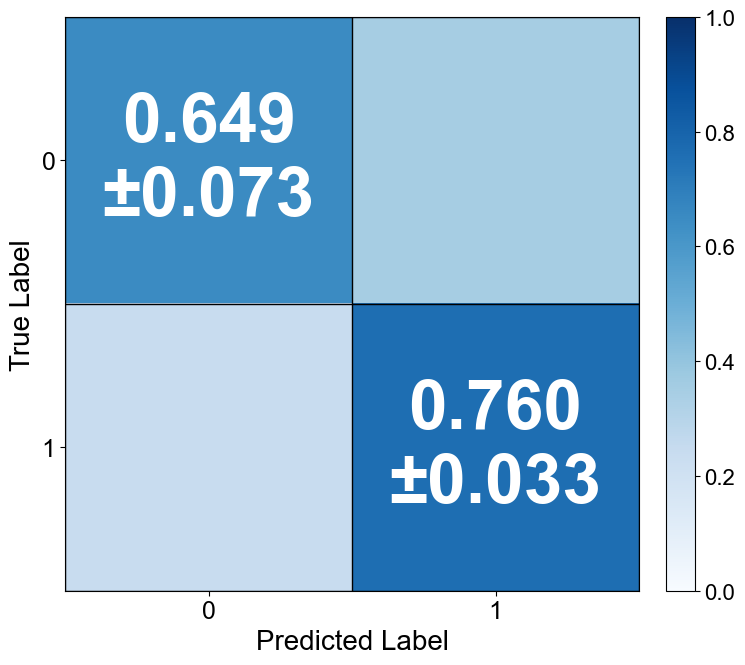

In [33]:
secondgen_seed42 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/second_gen_s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon14/confusion_matrix_values_epoch_76.npy")
secondgen_seed43 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/second_gen_s1_ep35_lr5_la1_seed43_ldim2_s2_lr6_la4_lc1_lcon14/confusion_matrix_values_epoch_13.npy")
secondgen_seed44 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/second_gen_s1_ep35_lr5_la1_seed44_ldim2_s2_lr6_la4_lc1_lcon14/confusion_matrix_values_epoch_18.npy")

conf_matrix_ai4cellfate = np.stack([secondgen_seed42, secondgen_seed43, secondgen_seed44], axis=0)

# Annotated mean confusion matrix with ± std (across 3 seeds)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Compute mean and std across seeds
mean_cm = np.mean(conf_matrix_ai4cellfate, axis=0)
std_cm = np.std(conf_matrix_ai4cellfate, axis=0)

# Use Arial and larger fonts
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(mean_cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)

# Title and labels
num_classes = mean_cm.shape[0]
ax.set_xlabel('Predicted Label', fontsize=20)
ax.set_ylabel('True Label', fontsize=20)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([str(i) for i in range(num_classes)], fontsize=18)
ax.set_yticklabels([str(i) for i in range(num_classes)], fontsize=18)

# Grid lines for clarity
ax.set_xticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='minor', bottom=False, left=False)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)

# Annotate ONLY diagonal cells with mean ± std in WHITE
for i in range(num_classes):
    for j in range(num_classes):
        if i == j:  # Only show values on the diagonal
            text = f"{mean_cm[i, j]:.3f}\n±{std_cm[i, j]:.3f}"
            ax.text(j, i, text, ha='center', va='center', color='white', fontsize=50, fontweight='bold')

plt.tight_layout()
#plt.savefig("second_gen_conf_matrix.eps", dpi=300, bbox_inches="tight")
plt.show()

 1/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


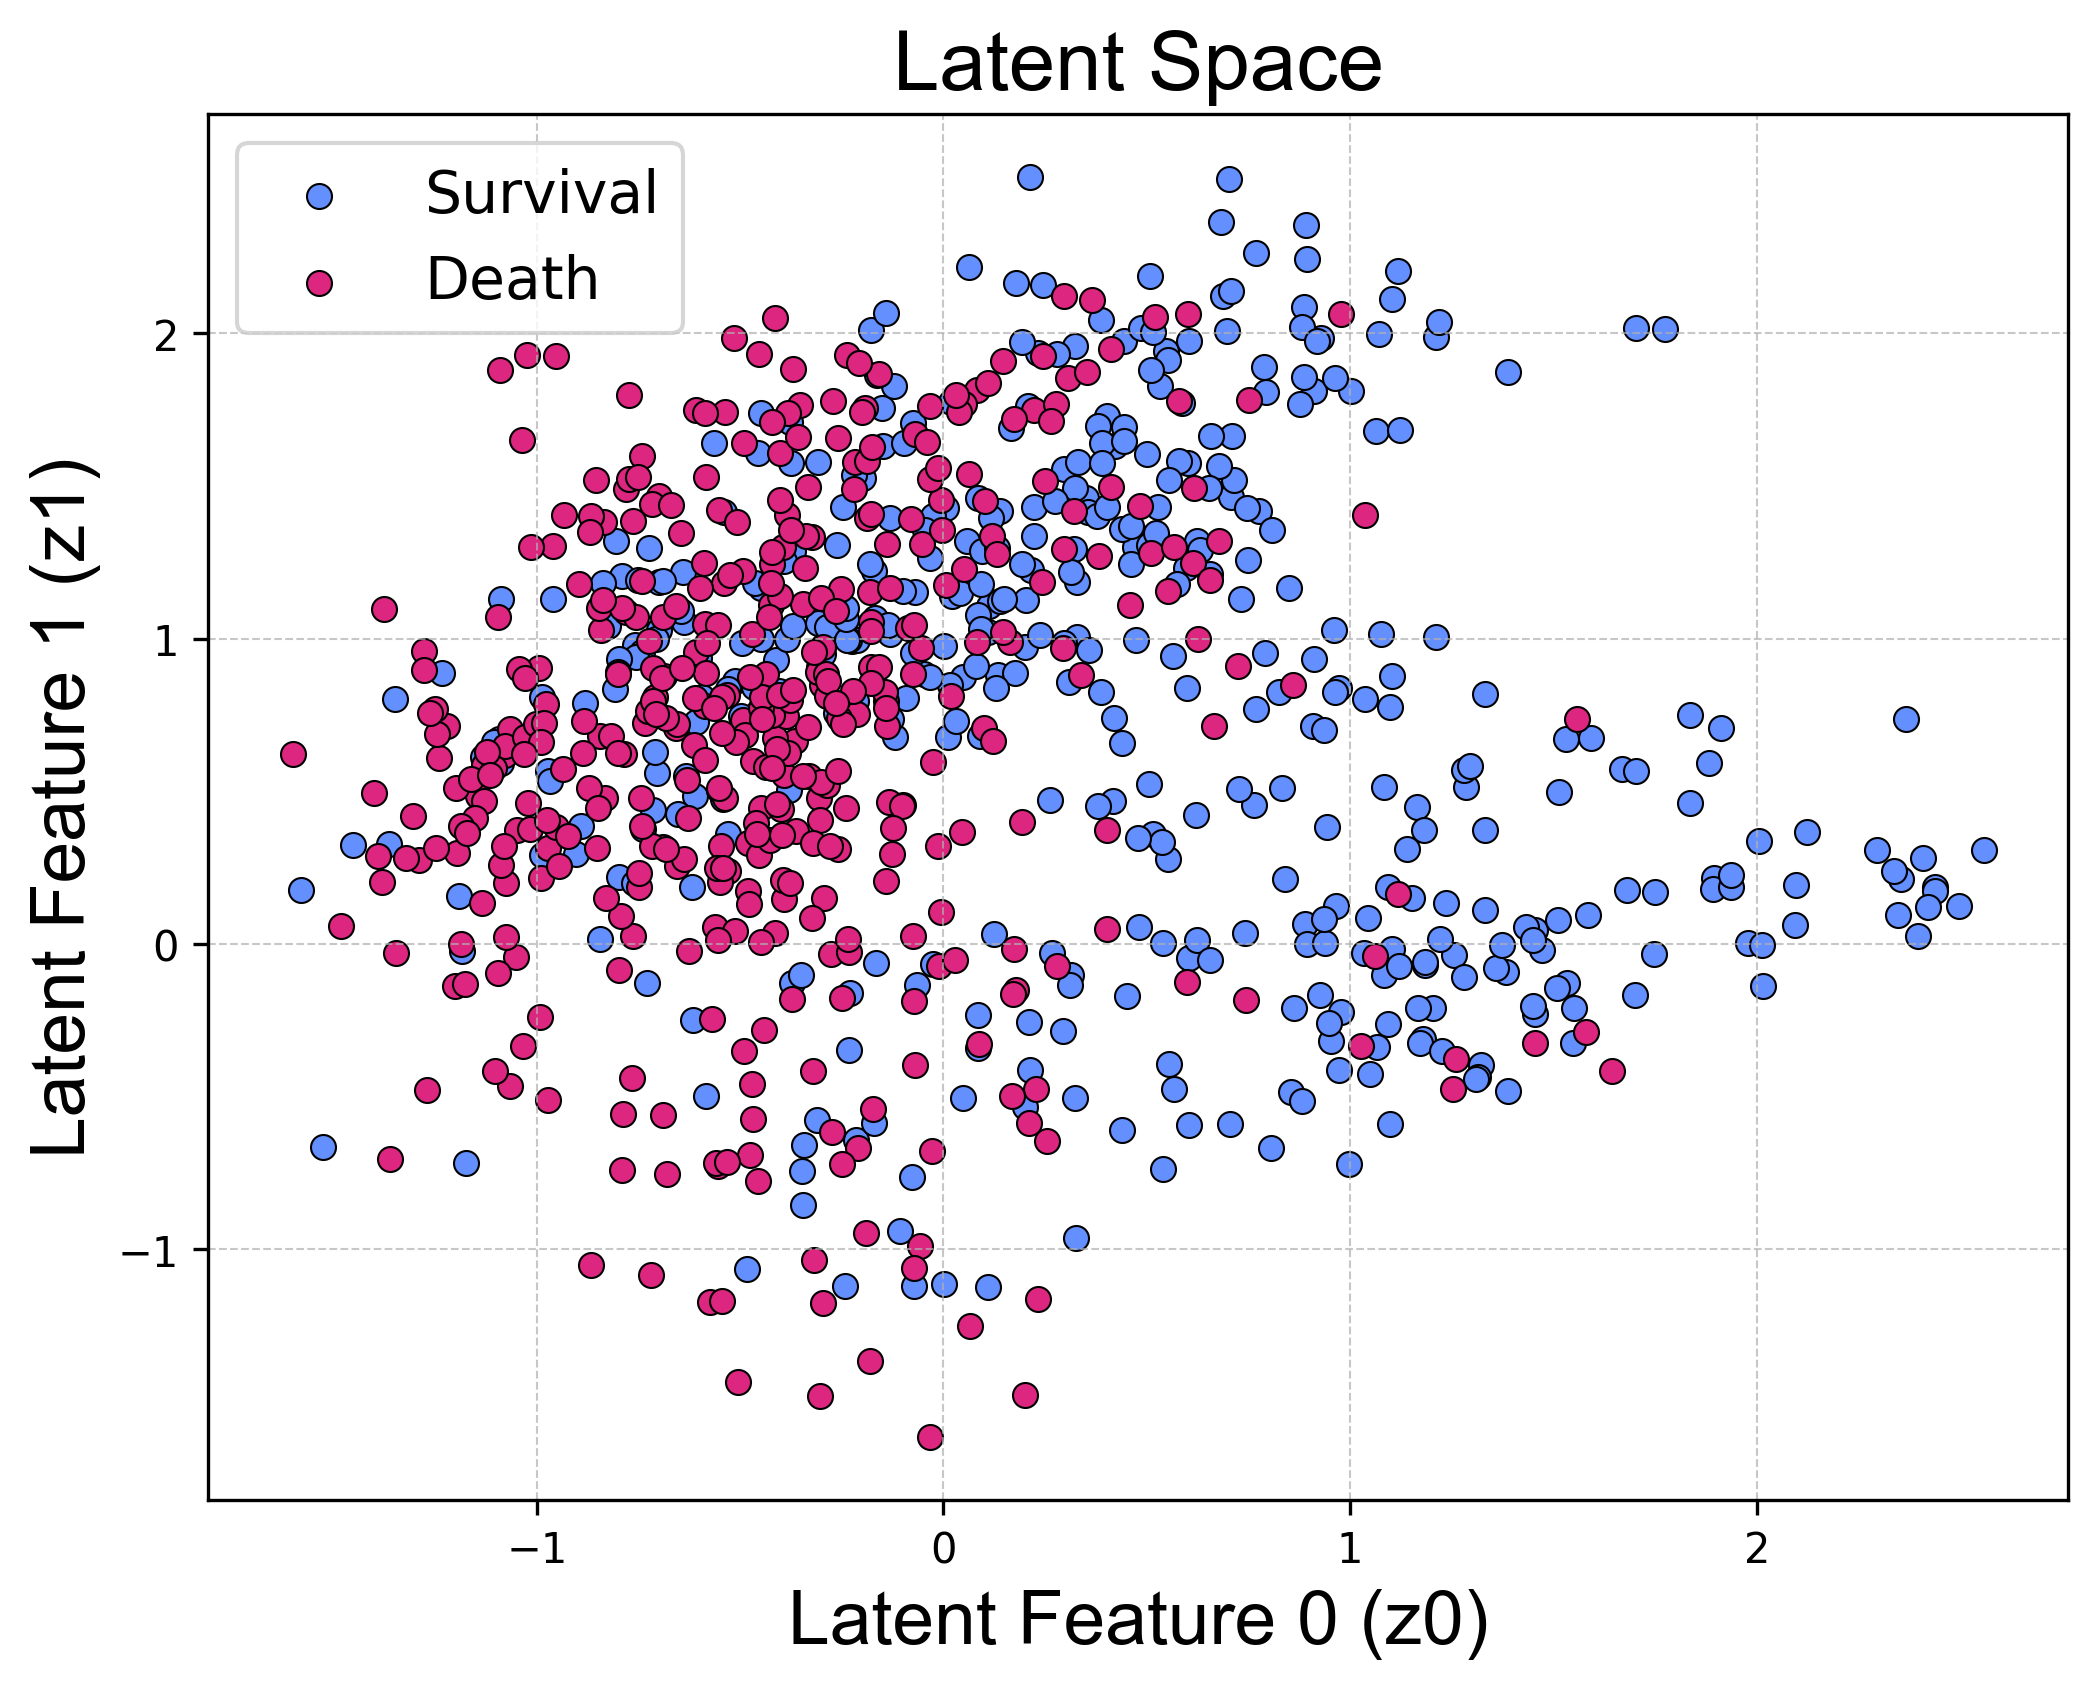

In [ ]:
# Predict the latent representations
latent_space = encoder.predict(x_train) 

cor_vals = [np.corrcoef(np.eye(2)[y_train][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
cor_vals = np.array(cor_vals)
feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:]  

# Scatter plot
#scatter = plt.scatter(latent_space[:, feat_0], latent_space[:, feat_1], c=y_train, cmap='viridis', alpha=0.7)
plt.figure(figsize=(8, 6), dpi=300)

plt.scatter(latent_space[y_train == feat_0][:, 0], latent_space[y_train == feat_0][:, 1], 
    color='#648fff', label="Survival", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_space[y_train == feat_1][:, 0], latent_space[y_train == feat_1][:, 1], 
    color='#dc267f', label="Death", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
#plt.savefig("LS_second_gen.eps", format="eps", dpi=600, bbox_inches="tight")


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


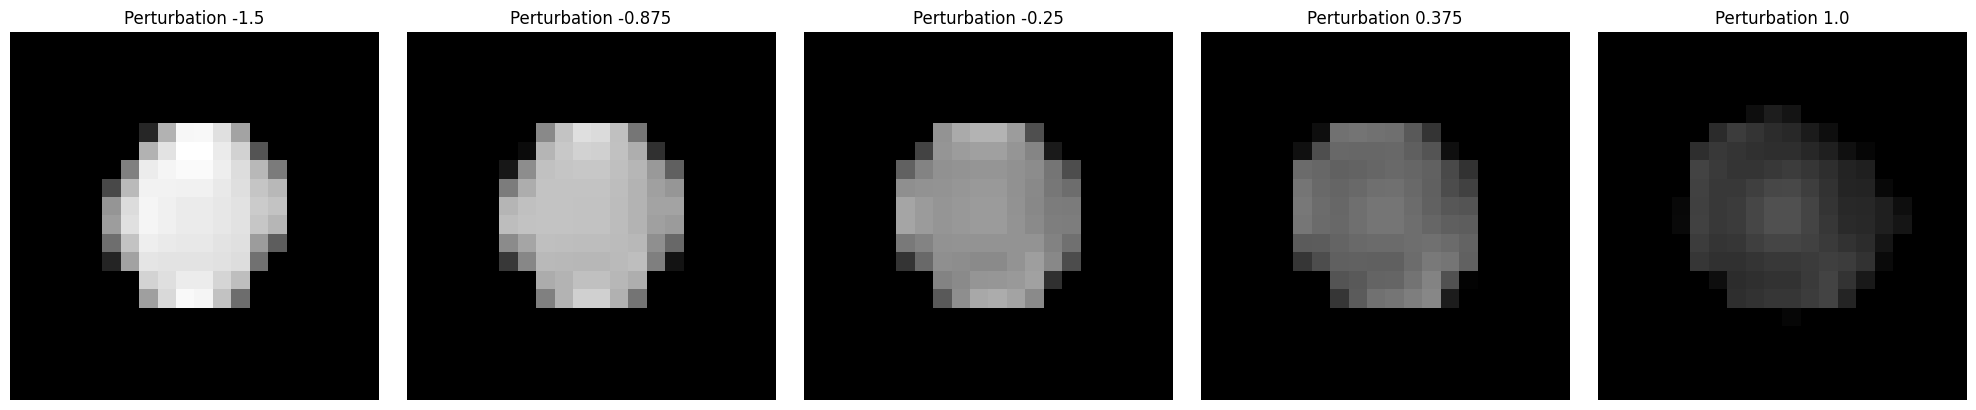

In [ ]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 0

# Perturbation range
perturbations = np.linspace(-1.5, 1, 5) # feature index 1

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.25, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    #fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("second_gen_perturbations_feat0.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


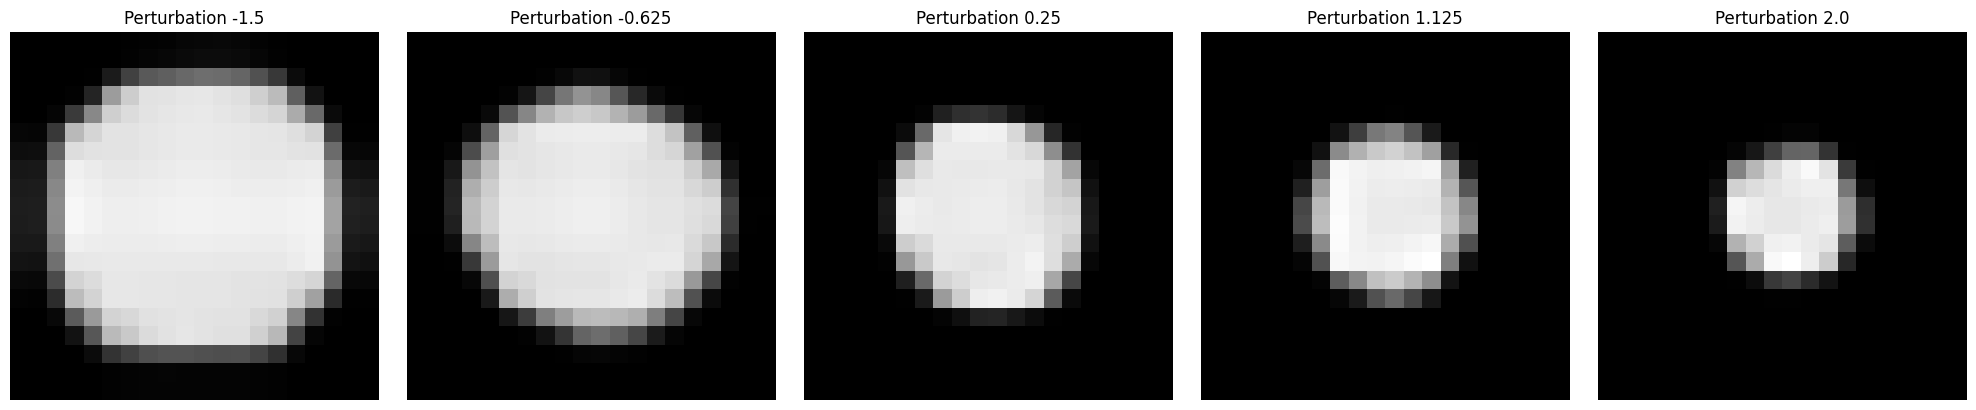

In [ ]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 1

# Perturbation range
perturbations = np.linspace(-1.5, 2, 5) # feature index 1
#perturbations = np.linspace(-2.5, 1.5, 5) # feature index 0

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.0, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    #fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("second_gen_perturbations_feat1.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


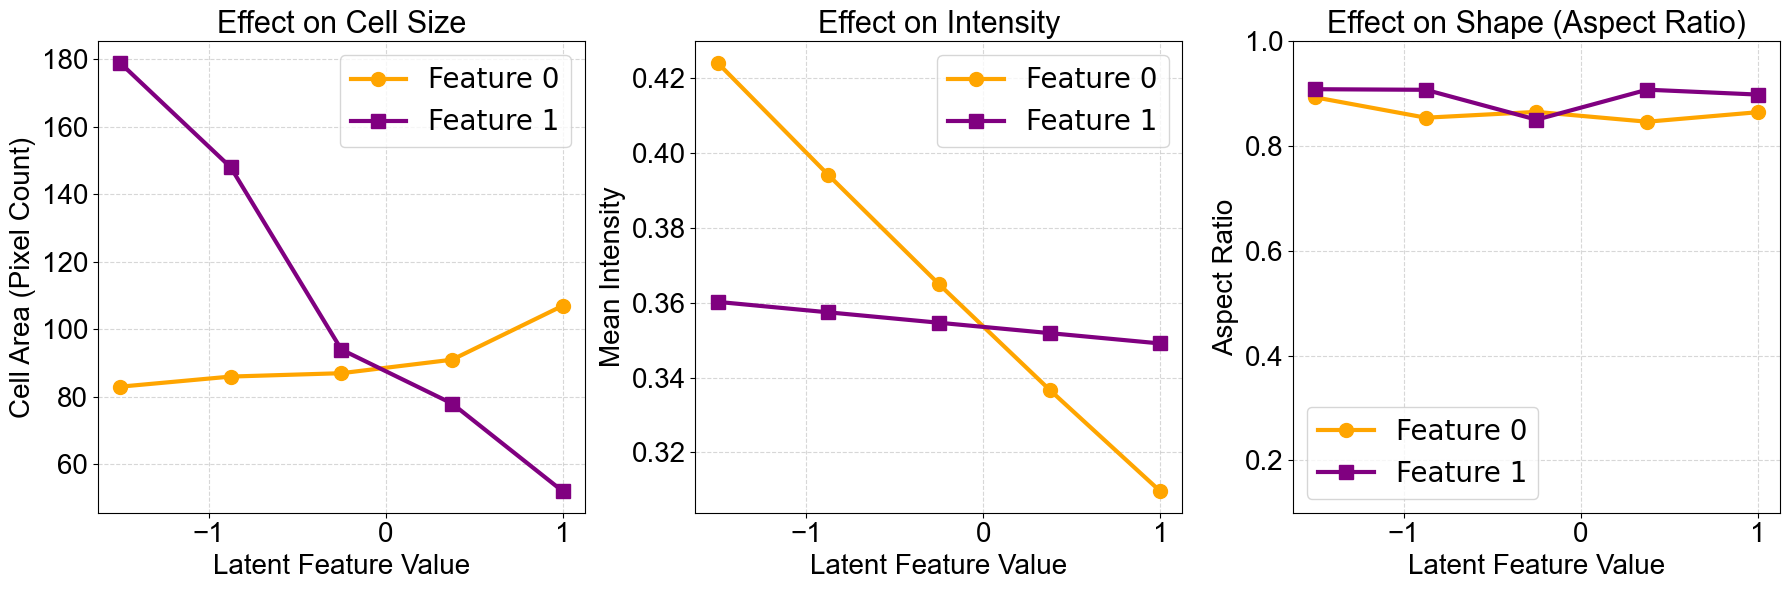

In [ ]:
import cv2

# Initialize arrays to store feature effects
areas_0, areas_1 = [], []
intensities_0, intensities_1 = [], []
aspect_ratios_0, aspect_ratios_1 = [], []
circularities_0, circularities_1 = [], []

# Function to compute cell area
def compute_area(image, threshold=0.25):
    return np.sum(image > threshold)

# def compute_intensity(image):
#     return np.max(image)

# Function to compute intensity at the center of the image
def compute_intensity(image):
    return image[image.shape[0]//2][image.shape[0]//2]


# Function to compute shape descriptors (aspect ratio, circularity)
def compute_shape_features(image, threshold=0.1):
    binary = (image > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return 0, 0  
    
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h
    
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    circularity = 4 * np.pi * (area / (perimeter ** 2 + 1e-6))  # Avoid division by zero
    
    return aspect_ratio, circularity

# Perturbation values
perturbations = np.linspace(-1.5, 1, 5)

# Iterate over both latent features
for feature_index in [0, 1]:
    for value in perturbations:
        # Create perturbed latent vector
        perturbed_vector = np.zeros((2, 2), dtype=np.float32)
        perturbed_vector[0, feature_index] = value

        # Decode the perturbed vector to generate a synthetic image
        synthetic_image = decoder.predict(perturbed_vector)[0, :, :, 0]

        # Compute features
        area = compute_area(synthetic_image)
        intensity = compute_intensity(synthetic_image)
        aspect_ratio, circularity = compute_shape_features(synthetic_image)

        # Store results based on the feature being perturbed
        if feature_index == 0:
            areas_0.append(area)
            intensities_0.append(intensity)
            aspect_ratios_0.append(aspect_ratio)
            circularities_0.append(circularity)
        else:
            areas_1.append(area)
            intensities_1.append(intensity)
            aspect_ratios_1.append(aspect_ratio)
            circularities_1.append(circularity)

# Define colors
# color_0 = "#E69F00"  # Orange
# color_1 = "#009E73"  # Teal
color_0 = "orange"
color_1 = "purple"

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Cell Area
axs[0].plot(perturbations, areas_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[0].plot(perturbations, areas_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[0].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[0].set_ylabel("Cell Area (Pixel Count)", fontsize=20, fontname="Arial")
axs[0].set_title("Effect on Cell Size", fontsize=22, fontname="Arial")
axs[0].legend(fontsize=20)
axs[0].grid(True, linestyle="--", alpha=0.5)
axs[0].tick_params(axis='both', which='major', labelsize=20)  # Make tick labels much bigger
for label in axs[0].get_xticklabels() + axs[0].get_yticklabels():
    label.set_fontname('Arial')

# Plot Mean Intensity
axs[1].plot(perturbations, intensities_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[1].plot(perturbations, intensities_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[1].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[1].set_ylabel("Mean Intensity", fontsize=20, fontname="Arial")
axs[1].set_title("Effect on Intensity", fontsize=22, fontname="Arial")
axs[1].legend(fontsize=20)
axs[1].grid(True, linestyle="--", alpha=0.5)
axs[1].tick_params(axis='both', which='major', labelsize=20)  # Make tick labels much bigger
for label in axs[1].get_xticklabels() + axs[1].get_yticklabels():
    label.set_fontname('Arial')

# Plot Shape Descriptors (Aspect Ratio)
axs[2].plot(perturbations, circularities_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[2].plot(perturbations, circularities_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[2].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[2].set_ylabel("Aspect Ratio", fontsize=20, fontname="Arial")
axs[2].set_title("Effect on Shape (Aspect Ratio)", fontsize=22, fontname="Arial")
axs[2].set_ylim(0.1, 1.0)
axs[2].legend(fontsize=20)
axs[2].grid(True, linestyle="--", alpha=0.5)
axs[2].tick_params(axis='both', which='major', labelsize=20)  # Make tick labels much bigger
for label in axs[2].get_xticklabels() + axs[2].get_yticklabels():
    label.set_fontname('Arial')

# Adjust layout and save as high-quality images
plt.tight_layout()
#plt.savefig("feature_effects_second_gen.eps", format="eps", bbox_inches="tight")

plt.show()